# MIE1622 - COMPUTATIONAL FINANCE AND RISK MANAGEMENT 
# ASSIGNMENT 3
# GOKUL RAVI - 1008312309

In [1]:
# importing libararies
import numpy as np
import pandas as pd
import scipy
import math
import scipy.stats as scs
from scipy import special
from scipy import sparse
from pathlib import Path
import matplotlib.pyplot as plt

In [2]:
Nout = 100000  # number of out-of-sample scenarios
Nin = 5000     # number of in-sample scenarios
Ns = 5         # number of idiosyncratic scenarios for each systemic
C = 8          # number of credit states

# Read and parse instrument data
instr_data = np.array(pd.read_csv('instrum_data.csv', header=None))
instr_id = instr_data[:, 0]     # ID
driver = instr_data[:, 1]       # credit driver
beta = instr_data[:, 2]         # beta (sensitivity to credit driver)
recov_rate = instr_data[:, 3]   # expected recovery rate
value = instr_data[:, 4]        # value
prob = instr_data[:, 5:(5 + C)] # credit-state migration probabilities (default to AAA)
exposure = instr_data[:, 5 + C:5 + 2 * C]  # credit-state migration exposures (default to AAA)
retn = instr_data[:, 5 + 2 * C] # market returns

K = instr_data.shape[0]         # number of CPs

# Read matrix of correlations for credit drivers
rho = np.array(pd.read_csv('credit_driver_corr.csv', sep='\t', header=None))
# Cholesky decomp of rho (for generating correlated Normal random numbers)
sqrt_rho = np.linalg.cholesky(rho)

print('======= Credit Risk Model with Credit-State Migrations =======')
print('============== Monte Carlo Scenario Generation ===============')
print(' ')
print(' ')
print(' Number of out-of-sample Monte Carlo scenarios = ' + str(Nout))
print(' Number of in-sample Monte Carlo scenarios = ' + str(Nin))
print(' Number of counterparties = ' + str(K))
print(' ')

# Find credit-state for each counterparty
# 8 = AAA, 7 = AA, 6 = A, 5 = BBB, 4 = BB, 3 = B, 2 = CCC, 1 = default
CS = np.argmax(prob, axis=1) + 1

#Account for default recoveries
exposure[:, 0] = (1 - recov_rate) * exposure[:, 0]

# Compute credit-state boundaries
CS_Bdry = scipy.special.ndtri((np.cumsum(prob[:, 0:C - 1], 1)))

======= Credit Risk Model with Credit-State Migrations =======
============== Monte Carlo Scenario Generation ===============
 
 
 Number of out-of-sample Monte Carlo scenarios = 100000
 Number of in-sample Monte Carlo scenarios = 5000
 Number of counterparties = 100
 


In [3]:
Ndrivers = len(rho)
filename_save_out = 'Losses_out'

if Path(filename_save_out+'.npz').is_file():
    Losses_out = scipy.sparse.load_npz(filename_save_out + '.npz')
else:
    # Generating Scenarios
    y = np.zeros((Nout, Ndrivers))
    w = np.zeros((Nout, K))
    Losses_out = np.zeros((Nout,K))
    for s in range(Nout):
        random_normal_factor = np.random.normal(0,1, (Ndrivers, 1)) 
        y[s,:] = np.dot(sqrt_rho,random_normal_factor).T
        z = np.random.normal(0, 1, (K,1))        
        for k in range(K):
            credit_driver = driver[k]-1      
            
            w[s,k] = beta[k]*y[s,int(credit_driver)] + math.sqrt(1-beta[k]**2)*z[k]  
            c_map = np.append(w[s,k], CS_Bdry[k,:])           
            c_level = np.sort(c_map)                       
            c_index = np.argwhere(c_level == w[s,k])     
            
            Losses_out[s,k] = exposure[k, c_index]
                 
    Losses_out = sparse.csr_matrix(Losses_out)
    scipy.sparse.save_npz(filename_save_out + '.npz', Losses_out)

In [5]:
# Normal approximation computed from out-of-sample scenarios
mu_l = np.mean(Losses_out, axis=0).reshape((K))
var_l = np.cov(Losses_out.toarray(), rowvar=False) # Losses_out as a sparse matrix

# Compute portfolio weights
portf_v = sum(value)  # portfolio value
w0 = []
w0.append(value / portf_v)   # asset weights (portfolio 1)
w0.append(np.ones((K)) / K)  # asset weights (portfolio 2)
x0 = []
x0.append((portf_v / value) * w0[0])  # asset units (portfolio 1)
x0.append((portf_v / value) * w0[1])  # asset units (portfolio 2)

# Quantile levels (99%, 99.9%)
alphas = np.array([0.99, 0.999])

VaRout = np.zeros((2, alphas.size))
VaRinN = np.zeros((2, alphas.size))
CVaRout = np.zeros((2, alphas.size))
CVaRinN = np.zeros((2, alphas.size))

Losses_out_port = []
Losses_out_port.append(np.sort(Losses_out*x0[0]))  
Losses_out_port.append(np.sort(Losses_out*x0[1]))  

for portN in range(2):
    # Compute VaR and CVaR
    for q in range(alphas.size):
        alf = alphas[q]
        VaRout[portN, q] = Losses_out_port[portN][int(math.ceil(Nout * alf)) - 1]
        
        VaRinN[portN, q] = np.mean(Losses_out_port[portN]) + scs.norm.ppf(alf) * np.std(Losses_out_port[portN])
        
        CVaRout[portN, q] = (1 / (Nout * (1 - alf))) * ((math.ceil(Nout * alf) - Nout * alf) 
                            * VaRout[portN, q] + sum(Losses_out_port[portN][int(math.ceil(Nout * alf)):]))
        
        CVaRinN[portN, q] = np.mean(Losses_out_port[portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) 
                                                               / (1 - alf)) * np.std(Losses_out_port[portN])

In [ ]:
# Perform 100 trials
N_trials = 100
portf_loss_inMC1 = np.zeros((N_trials, 2, Nin))
portf_loss_inMC2 = np.zeros((N_trials, 2, Nin))

VaRinMC1 = {}
VaRinMC2 = {}
VaRinN1 = {}
VaRinN2 = {}
CVaRinMC1 = {}
CVaRinMC2 = {}
CVaRinN1 = {}
CVaRinN2 = {}

for portN in range(2):
    for q in range(alphas.size):
        VaRinMC1[portN, q] = np.zeros(N_trials)
        VaRinMC2[portN, q] = np.zeros(N_trials)
        VaRinN1[portN, q] = np.zeros(N_trials)
        VaRinN2[portN, q] = np.zeros(N_trials)
        CVaRinMC1[portN, q] = np.zeros(N_trials)
        CVaRinMC2[portN, q] = np.zeros(N_trials)
        CVaRinN1[portN, q] = np.zeros(N_trials)
        CVaRinN2[portN, q] = np.zeros(N_trials)

In [6]:
for tr in range(N_trials):
    # Monte Carlo approximation 1
    N_MC1 = np.int(np.ceil(Nin / Ns))
    i = 0
    w_MC1 = np.zeros((N_MC1, Ns, K))             
    y_MC1 = np.zeros((N_MC1, Ndrivers))                 
    Losses_MC1_per = np.zeros((N_MC1, Ns, K))    
    Losses_inMC1 = np.zeros((Nin, K))              
    for s in range(N_MC1):
        credit_state = np.zeros((Nout,K))        
        normal_random_vector =np.random.normal(0,1, (Ndrivers, 1))
        y_MC1[s,:] = np.dot(sqrt_rho,normal_random_vector).T
        
        for si in range(Ns): # idiosyncratic scenarios for each systemic
            z_MC1 = np.random.normal(0,1, (K, 1))
            # Calculate losses for MC1 approximation (5000 x 100)
            for k in range(K):
                credit_driver = driver[k]-1   
                
                # Compute credit worthiness index 
                w_MC1[s,si,k] = beta[k]*y_MC1[s,int(credit_driver)] + math.sqrt(1-beta[k]**2)*z_MC1[k] 
                c_map_MC1 = np.append(w_MC1[s,si][k], CS_Bdry[k,:])               
                c_level = np.sort(c_map_MC1)                       
                c_index = np.argwhere(c_level == w_MC1[s,si][k]) 
                
                #Calculated in-sample losses (1000x 5 x 100)
                Losses_MC1_per[s,si,k] = exposure[k, c_index]
                
            # Compute loss for Monte Carlo simulation 1 samples
            Losses_inMC1[i,:] = Losses_MC1_per[s,si]
            i = i+1
    
    # Monte Carlo approximation 2

    w_MC2 = np.zeros((Nin,K))                        
    y_MC2 = np.zeros((Nin, Ndrivers))                 
    Losses_inMC2 = np.zeros((Nin, K))                   
    for s in range(Nin): # systemic scenarios (1 idiosyncratic scenario for each systemic)
        

        normal_random_vector =np.random.normal(0,1, (Ndrivers, 1))
        y_MC2[s,:] = np.dot(sqrt_rho,normal_random_vector).T
        z_MC2 = np.random.normal(0,1, (K, 1))
        for k in range(K):
            credit_driver = driver[k]-1   
            
            # Compute credit worthiness index 
            w_MC2[s,k] = beta[k]*y_MC2[s,int(credit_driver)] + math.sqrt(1-beta[k]**2)*z_MC2[k]  
            c_map_MC2 = np.append(w_MC2[s,k], CS_Bdry[k,:])               
            c_level = np.sort(c_map_MC2)                      
            c_index = np.argwhere(c_level == w_MC2[s,k])
            
            # Losses_inMC2, Calculated losses for MC2 approximation (5000 x 100)
            Losses_inMC2[s,k] = exposure[k, c_index] 
    
    # Compute VaR and CVaR
    for portN in range(2):
        for q in range(alphas.size):
            alf = alphas[q]
            
            # Compute portfolio loss
            portf_loss_inMC1[tr, portN] = np.sort(np.dot(Losses_inMC1,x0[portN]))
            portf_loss_inMC2[tr, portN] = np.sort(np.dot(Losses_inMC2,x0[portN]))
            mu_MC1 = np.mean(Losses_inMC1, axis=0).reshape((K))
            var_MC1 = np.cov(Losses_inMC1, rowvar=False)
            mu_MC2 = np.mean(Losses_inMC2, axis=0).reshape((K))
            var_MC2 = np.cov(Losses_inMC2, rowvar=False)
            
            # Compute portfolio mean loss mu_p_MC1 and portfolio standard deviation of losses sigma_p_MC1
            mu_p_MC1 = np.dot(mu_MC1, x0[portN])
            sigma_p_MC1 = np.std(portf_loss_inMC1[tr, portN])
            
            # Compute portfolio mean loss mu_p_MC2 and portfolio standard deviation of losses sigma_p_MC2
            mu_p_MC2 = np.dot(mu_MC2, x0[portN])
            sigma_p_MC2 = np.std(portf_loss_inMC2[tr, portN])
            
            # Compute VaR and CVaR for the current trial
            VaRinMC1[portN, q][tr] = portf_loss_inMC1[tr, portN][int(math.ceil(Nin * alf)) - 1]
            VaRinMC2[portN, q][tr] = portf_loss_inMC2[tr, portN][int(math.ceil(Nin * alf)) - 1]
            VaRinN1[portN, q][tr] =  np.mean(portf_loss_inMC1[tr, portN]) + scs.norm.ppf(alf) * sigma_p_MC1  
            VaRinN2[portN, q][tr] =  np.mean(portf_loss_inMC2[tr, portN]) + scs.norm.ppf(alf) * sigma_p_MC2  
            CVaRinMC1[portN, q][tr] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC1[portN, q][tr] + sum(portf_loss_inMC1[tr, portN][int(math.ceil(Nin * alf)):]))
            CVaRinMC2[portN, q][tr] = (1 / (Nin * (1 - alf))) * ((math.ceil(Nin * alf) - Nin * alf) * VaRinMC2[portN, q][tr] + sum(portf_loss_inMC2[tr, portN][int(math.ceil(Nin * alf)):]))
            CVaRinN1[portN, q][tr] =  np.mean(portf_loss_inMC1[tr, portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC1
            CVaRinN2[portN, q][tr] =  np.mean(portf_loss_inMC2[tr, portN]) + (scs.norm.pdf(scs.norm.ppf(alf)) / (1 - alf)) * sigma_p_MC2
  

C:\Users\gokul\AppData\Local\Temp\ipykernel_27768\2203486440.py:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  N_MC1 = np.int(np.ceil(Nin / Ns))


In [7]:
# Display VaR and CVaR

for portN in range(2):
    print('\nPortfolio {}:\n'.format(portN + 1))
    for q in range(alphas.size):
        alf = alphas[q]
        print('Out-of-sample: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRout[portN, q], 100 * alf, CVaRout[portN, q]))
        print('In-sample MC1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC1[portN, q]), 100 * alf, np.mean(CVaRinMC1[portN, q])))
        print('In-sample MC2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinMC2[portN, q]), 100 * alf, np.mean(CVaRinMC2[portN, q])))
        print('In-sample No: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, VaRinN[portN, q], 100 * alf, CVaRinN[portN, q]))
        print('In-sample N1: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f' % (
        100 * alf, np.mean(VaRinN1[portN, q]), 100 * alf, np.mean(CVaRinN1[portN, q])))
        print('In-sample N2: VaR %4.1f%% = $%6.2f, CVaR %4.1f%% = $%6.2f\n' % (
        100 * alf, np.mean(VaRinN2[portN, q]), 100 * alf, np.mean(CVaRinN2[portN, q])))


Portfolio 1:

Out-of-sample: VaR 99.0% = $37666279.94, CVaR 99.0% = $45034879.25
In-sample MC1: VaR 99.0% = $37157775.62, CVaR 99.0% = $44502412.06
In-sample MC2: VaR 99.0% = $37130019.19, CVaR 99.0% = $44614420.86
In-sample No: VaR 99.0% = $26340650.01, CVaR 99.0% = $29247491.72
In-sample N1: VaR 99.0% = $26132247.17, CVaR 99.0% = $29013876.21
In-sample N2: VaR 99.0% = $26150788.56, CVaR 99.0% = $29034950.86

Out-of-sample: VaR 99.9% = $53739612.18, CVaR 99.9% = $61424967.94
In-sample MC1: VaR 99.9% = $53395129.31, CVaR 99.9% = $60221205.74
In-sample MC2: VaR 99.9% = $53944397.65, CVaR 99.9% = $61236577.71
In-sample No: VaR 99.9% = $32893354.80, CVaR 99.9% = $35268278.49
In-sample N1: VaR 99.9% = $32628116.67, CVaR 99.9% = $34982441.33
In-sample N2: VaR 99.9% = $32652368.61, CVaR 99.9% = $35008762.97


Portfolio 2:

Out-of-sample: VaR 99.0% = $27831890.32, CVaR 99.0% = $33811414.20
In-sample MC1: VaR 99.0% = $27361519.11, CVaR 99.0% = $33350780.48
In-sample MC2: VaR 99.0% = $27329846

In [26]:
#Sample Tables for errors
sample_error={}
for portN in range(2):
    for q in range(alphas.size):
        alf=alphas[q]
        alpha_str="{:.1%}".format(alf) if alf !=0.99 else "99%"
        sample_error[f"{alpha_str} VaR, MC1, Portfolio {portN+1}"] = ((np.mean(VaRinMC1[portN,q])-VaRout[portN,q])/VaRout[portN,q])*100
        sample_error[f"{alpha_str} CVaR, MC1, Portfolio {portN+1}"] = ((np.mean(CVaRinMC1[portN,q])-CVaRout[portN,q])/CVaRout[portN,q])*100
        sample_error[f"{alpha_str} VaR, MC2, Portfolio {portN+1}"] = ((np.mean(VaRinMC2[portN,q])-VaRout[portN,q])/VaRout[portN,q])*100
        sample_error[f"{alpha_str} CVaR, MC2, Portfolio {portN+1}"] = ((np.mean(CVaRinMC2[portN,q])-CVaRout[portN,q])/CVaRout[portN,q])*100
pd.options.display.float_format = "{:,.2f}%".format
df_mc = pd.DataFrame(sample_error.values(), index=sample_error.keys(), columns=["Sampling Error (% difference)"])
df_mc

,Sampling Error (% difference)
"99% VaR, MC1, Portfolio 1",-1.35%
"99% CVaR, MC1, Portfolio 1",-1.18%
"99% VaR, MC2, Portfolio 1",-1.42%
"99% CVaR, MC2, Portfolio 1",-0.93%
"99.9% VaR, MC1, Portfolio 1",-0.64%
"99.9% CVaR, MC1, Portfolio 1",-1.96%
"99.9% VaR, MC2, Portfolio 1",0.38%
"99.9% CVaR, MC2, Portfolio 1",-0.31%
"99% VaR, MC1, Portfolio 2",-1.69%
"99% CVaR, MC1, Portfolio 2",-1.36%


In [28]:
#Model Tables for errors
model_error={}
for portN in range(2):
    for q in range(alphas.size):
        alf=alphas[q]
        alpha_str="{:.1%}".format(alf) if alf !=0.99 else "99%"
        model_error[f"{alpha_str} VaR, N1, Portfolio {portN+1}"] = ((np.mean(VaRinN1[portN,q])-VaRout[portN,q])/VaRout[portN,q])*100
        model_error[f"{alpha_str} CVaR, N1, Portfolio {portN+1}"] = ((np.mean(CVaRinN1[portN,q])-CVaRout[portN,q])/CVaRout[portN,q])*100
        model_error[f"{alpha_str} VaR, N2, Portfolio {portN+1}"] = ((np.mean(VaRinN2[portN,q])-VaRout[portN,q])/VaRout[portN,q])*100
        model_error[f"{alpha_str} CVaR, N2, Portfolio {portN+1}"] = ((np.mean(CVaRinN2[portN,q])-CVaRout[portN,q])/CVaRout[portN,q])*100
pd.options.display.float_format = "{:,.2f}%".format
df_Me = pd.DataFrame(model_error.values(), index=model_error.keys(), columns=["Model Error (% difference)"])
df_Me

,Model Error (% difference)
"99% VaR, N1, Portfolio 1",-30.62%
"99% CVaR, N1, Portfolio 1",-35.57%
"99% VaR, N2, Portfolio 1",-30.57%
"99% CVaR, N2, Portfolio 1",-35.53%
"99.9% VaR, N1, Portfolio 1",-39.28%
"99.9% CVaR, N1, Portfolio 1",-43.05%
"99.9% VaR, N2, Portfolio 1",-39.24%
"99.9% CVaR, N2, Portfolio 1",-43.01%
"99% VaR, N1, Portfolio 2",-24.27%
"99% CVaR, N1, Portfolio 2",-31.27%


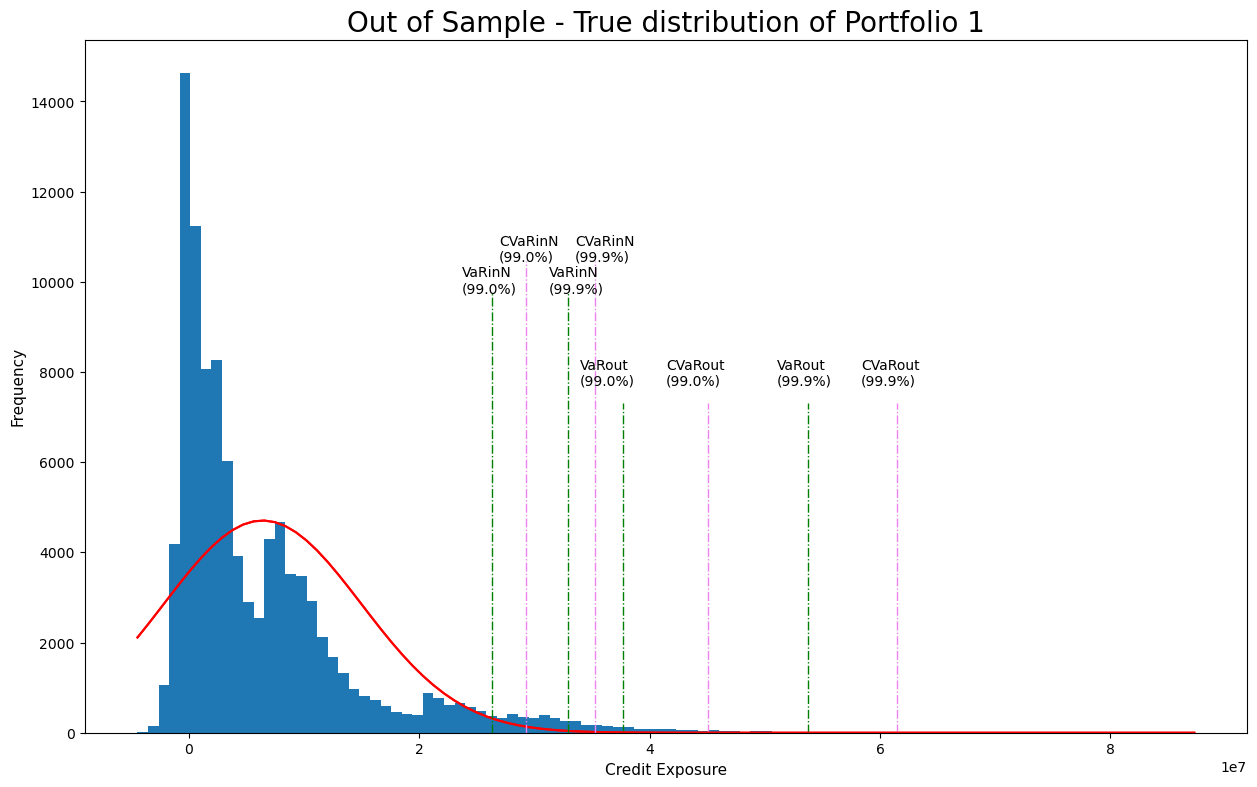

In [31]:
# Plot results
# Portfolio 1 - Out of sample portfolio loss distribution , N=100000

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[0], 100)
normf = (1 / (np.std(Losses_out_port[0]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[0])) / np.std(Losses_out_port[0])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRout[0,0], VaRout[0,0]], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[0,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[0,1], VaRout[0,1]], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[0,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[0,0], CVaRout[0,0]], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[0,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[0,1], CVaRout[0,1]], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[0,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[0,0], VaRinN[0,0]], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[0,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[0,1], VaRinN[0,1]], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[0,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[0,0], CVaRinN[0,0]], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[0,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[0,1], CVaRinN[0,1]], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[0,1], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.9%)')

plt.title('Out of Sample - True distribution of Portfolio 1', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);

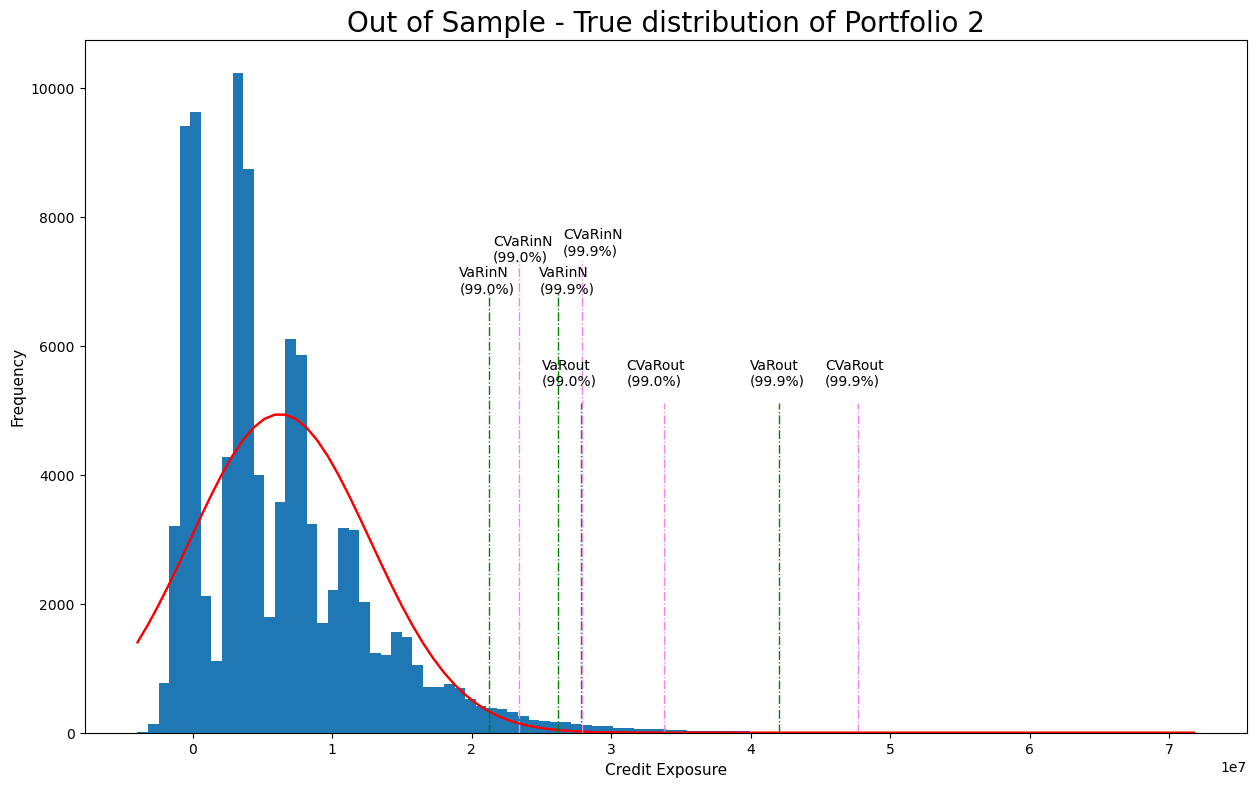

In [39]:
# Portfolio 2 - Out of sample portfolio loss distribution , N=100000

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(Losses_out_port[1], 100)
normf = (1 / (np.std(Losses_out_port[1]) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(Losses_out_port[1])) / np.std(Losses_out_port[1])) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)

# Plot non-Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot([VaRout[1,0], VaRout[1,0]], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRout[1,0], max(frequencyCounts) / 1.9, 'VaRout\n(99.0%)')
plt.plot([VaRout[1,1], VaRout[1,1]], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRout[1,1], max(frequencyCounts) / 1.9, 'VaRout\n(99.9%)')
plt.plot([CVaRout[1,0], CVaRout[1,0]], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRout[1,0], max(frequencyCounts) / 1.9, 'CVaRout\n(99.0%)')
plt.plot([CVaRout[1,1], CVaRout[1,1]], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRout[1,1], max(frequencyCounts) / 1.9, 'CVaRout\n(99.9%)')

# Plot Normal VaR and CVaR at 99.0% and 99.9% quantile
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinN[1,0], VaRinN[1,0]], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.90 * VaRinN[1,0], max(frequencyCounts) / 1.5, 'VaRinN\n(99.0%)')
plt.plot([VaRinN[1,1], VaRinN[1,1]], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN[1,1], max(frequencyCounts) / 1.5, 'VaRinN\n(99.9%)')
plt.plot([CVaRinN[1,0], CVaRinN[1,0]], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN[1,0], max(frequencyCounts) / 1.4, 'CVaRinN\n(99.0%)')
plt.plot([CVaRinN[1,1], CVaRinN[1,1]], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN[1,1], max(frequencyCounts) / 1.38, 'CVaRinN\n(99.9%)')


plt.title('Out of Sample - True distribution of Portfolio 2', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);

In [10]:
port_loss_inMC1_p1 = np.zeros((5000,))
port_loss_inMC1_p2 = np.zeros((5000,))
port_loss_inMC2_p1 = np.zeros((5000,))
port_loss_inMC2_p2 = np.zeros((5000,))

for i in range(N_trials):
    port_loss_inMC1_p1 = port_loss_inMC1_p1 + portf_loss_inMC1[i,0]*0.01
    port_loss_inMC1_p2 = port_loss_inMC1_p2 + portf_loss_inMC1[i,1]*0.01
    port_loss_inMC2_p1 = port_loss_inMC2_p1 + portf_loss_inMC2[i,0]*0.01
    port_loss_inMC2_p2 = port_loss_inMC2_p2 + portf_loss_inMC2[i,1]*0.01

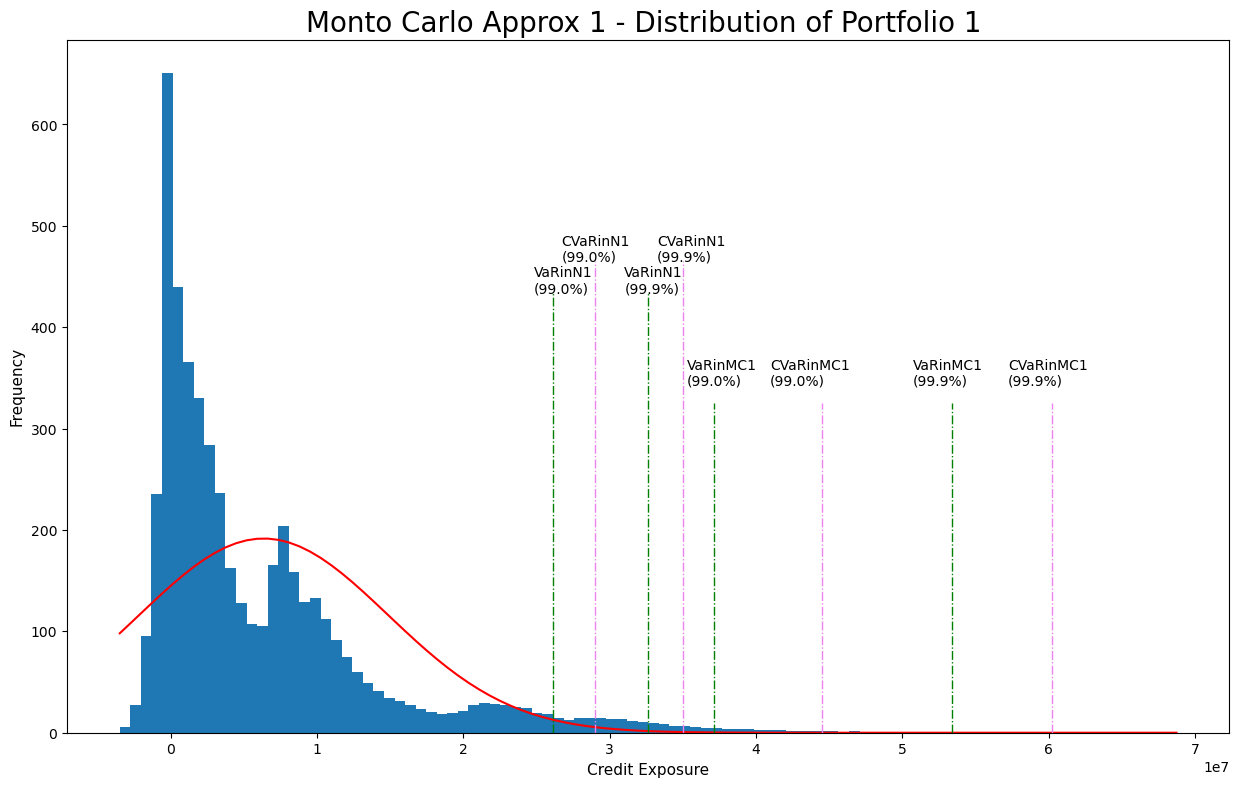

In [35]:
# Distribution of Portfolio 1 - Monte Carlo approximation 1, N = 1000x5
VaRinMC1_p1_99 = np.mean(VaRinMC1[0, 0])
VaRinMC1_p1_999 = np.mean(VaRinMC1[0, 1])
CVaRinMC1_p1_99 = np.mean(CVaRinMC1[0, 0])
CVaRinMC1_p1_999 = np.mean(CVaRinMC1[0, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p1, 100)
normf = (1 / (np.std(port_loss_inMC1_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p1)) / np.std(port_loss_inMC1_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p1_99, VaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p1_999, VaRinMC1_p1_999], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p1_999, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p1_99, CVaRinMC1_p1_99], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p1_999, CVaRinMC1_p1_999], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p1_999, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 1 
VaRinN1_p1_99 = np.mean(VaRinN1[0, 0])
VaRinN1_p1_999 = np.mean(VaRinN1[0, 1])
CVaRinN1_p1_99 = np.mean(CVaRinN1[0, 0])
CVaRinN1_p1_999 = np.mean(CVaRinN1[0, 1])

plt.plot([VaRinN1_p1_99, VaRinN1_p1_99], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p1_999, VaRinN1_p1_999], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p1_999, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p1_99, CVaRinN1_p1_99], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p1_999, CVaRinN1_p1_999], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p1_999, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Monto Carlo Approx 1 - Distribution of Portfolio 1 ', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);

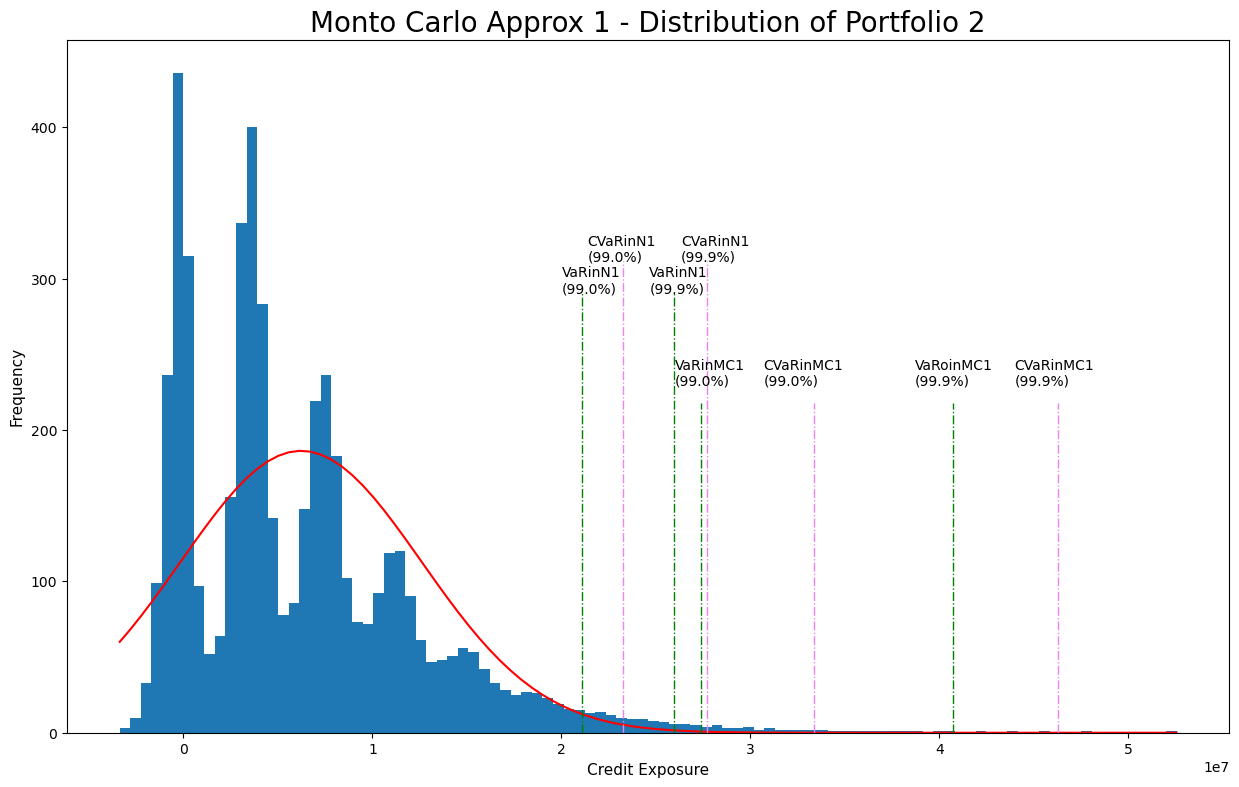

In [37]:
# Distribution of Portfolio 2 Monte Carlo approximation 1, N = 1000x5
VaRinMC1_p2_99 = np.mean(VaRinMC1[1, 0])
VaRinMC1_p2_999 = np.mean(VaRinMC1[1, 1])
CVaRinMC1_p2_99 = np.mean(CVaRinMC1[1, 0])
CVaRinMC1_p2_999 = np.mean(CVaRinMC1[1, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC1_p2, 100)
normf = (1 / (np.std(port_loss_inMC1_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC1_p2)) / np.std(port_loss_inMC1_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC1_p2_99, VaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC1\n(99.0%)')
plt.plot([VaRinMC1_p2_999, VaRinMC1_p2_999], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC1_p2_999, max(frequencyCounts) / 1.9, 'VaRoinMC1\n(99.9%)')
plt.plot([CVaRinMC1_p2_99, CVaRinMC1_p2_99], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC1_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.0%)')
plt.plot([CVaRinMC1_p2_999, CVaRinMC1_p2_999], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC1_p2_999, max(frequencyCounts) / 1.9, 'CVaRinMC1\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 2
VaRinN1_p2_99 = np.mean(VaRinN1[1, 0])
VaRinN1_p2_999 = np.mean(VaRinN1[1, 1])
CVaRinN1_p2_99 = np.mean(CVaRinN1[1, 0])
CVaRinN1_p2_999 = np.mean(CVaRinN1[1, 1])

plt.plot([VaRinN1_p2_99, VaRinN1_p2_99], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_99, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.0%)')
plt.plot([VaRinN1_p2_999, VaRinN1_p2_999], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN1_p2_999, max(frequencyCounts) / 1.5, 'VaRinN1\n(99.9%)')
plt.plot([CVaRinN1_p2_99, CVaRinN1_p2_99], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN1_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.0%)')
plt.plot([CVaRinN1_p2_999, CVaRinN1_p2_999], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN1_p2_999, max(frequencyCounts) / 1.4, 'CVaRinN1\n(99.9%)')


plt.title('Monto Carlo Approx 1 - Distribution of Portfolio 2', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);

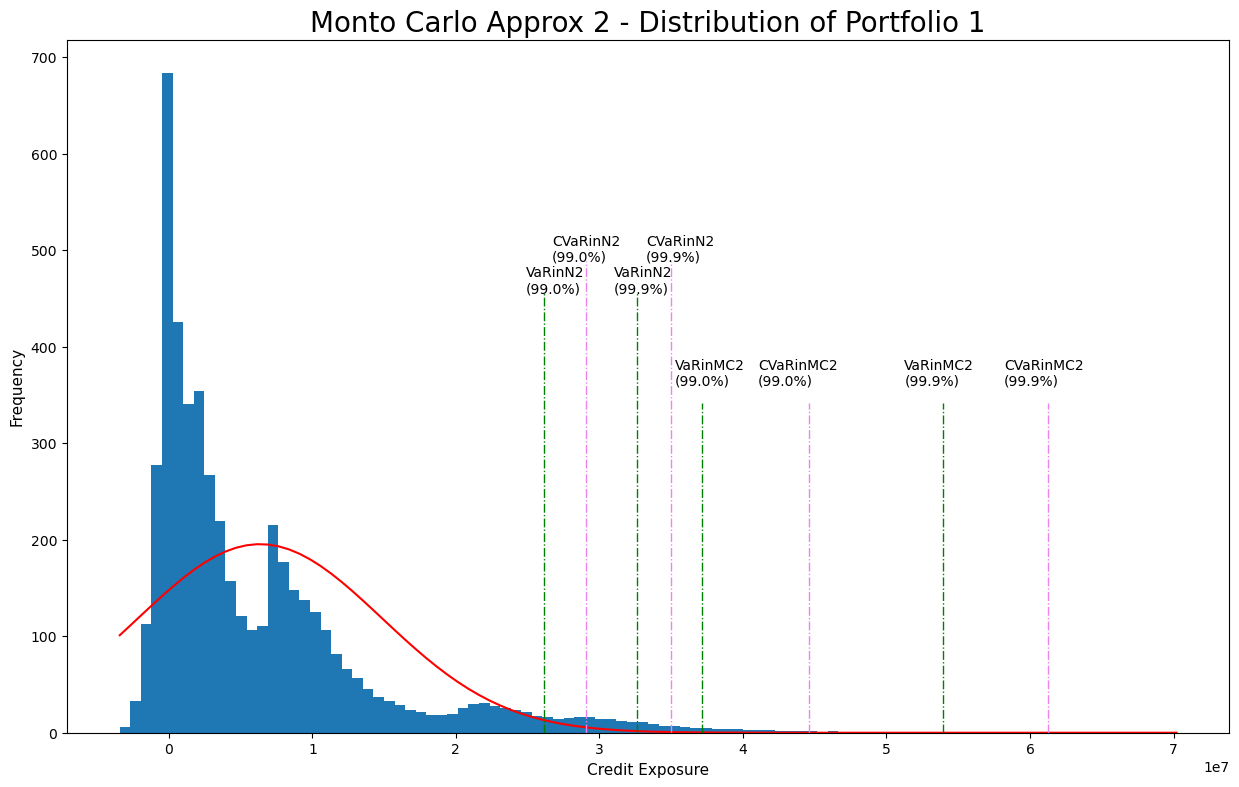

In [40]:
# Distribution of Portfolio 1 Monte Carlo approximation 2, N = 5000
VaRinMC2_p1_99 = np.mean(VaRinMC2[0, 0])
VaRinMC2_p1_999 = np.mean(VaRinMC2[0, 1])
CVaRinMC2_p1_99 = np.mean(CVaRinMC2[0, 0])
CVaRinMC2_p1_999 = np.mean(CVaRinMC2[0, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p1, 100)
normf = (1 / (np.std(port_loss_inMC2_p1) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p1)) / np.std(port_loss_inMC2_p1)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p1_99, VaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p1_999, VaRinMC2_p1_999], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p1_999, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p1_99, CVaRinMC2_p1_99], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p1_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p1_999, CVaRinMC2_p1_999], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p1_999, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

# Normal distribution of Monte Carlo approximation 2, portfolio 1 
VaRinN2_p1_99 = np.mean(VaRinN2[0, 0])
VaRinN2_p1_999 = np.mean(VaRinN2[0, 1])
CVaRinN2_p1_99 = np.mean(CVaRinN2[0, 0])
CVaRinN2_p1_999 = np.mean(CVaRinN2[0, 1])

plt.plot([VaRinN2_p1_99, VaRinN2_p1_99], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p1_999, VaRinN2_p1_999], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p1_999, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p1_99, CVaRinN2_p1_99], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p1_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p1_999, CVaRinN2_p1_999], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p1_999, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')

plt.title('Monto Carlo Approx 2 - Distribution of Portfolio 1', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);

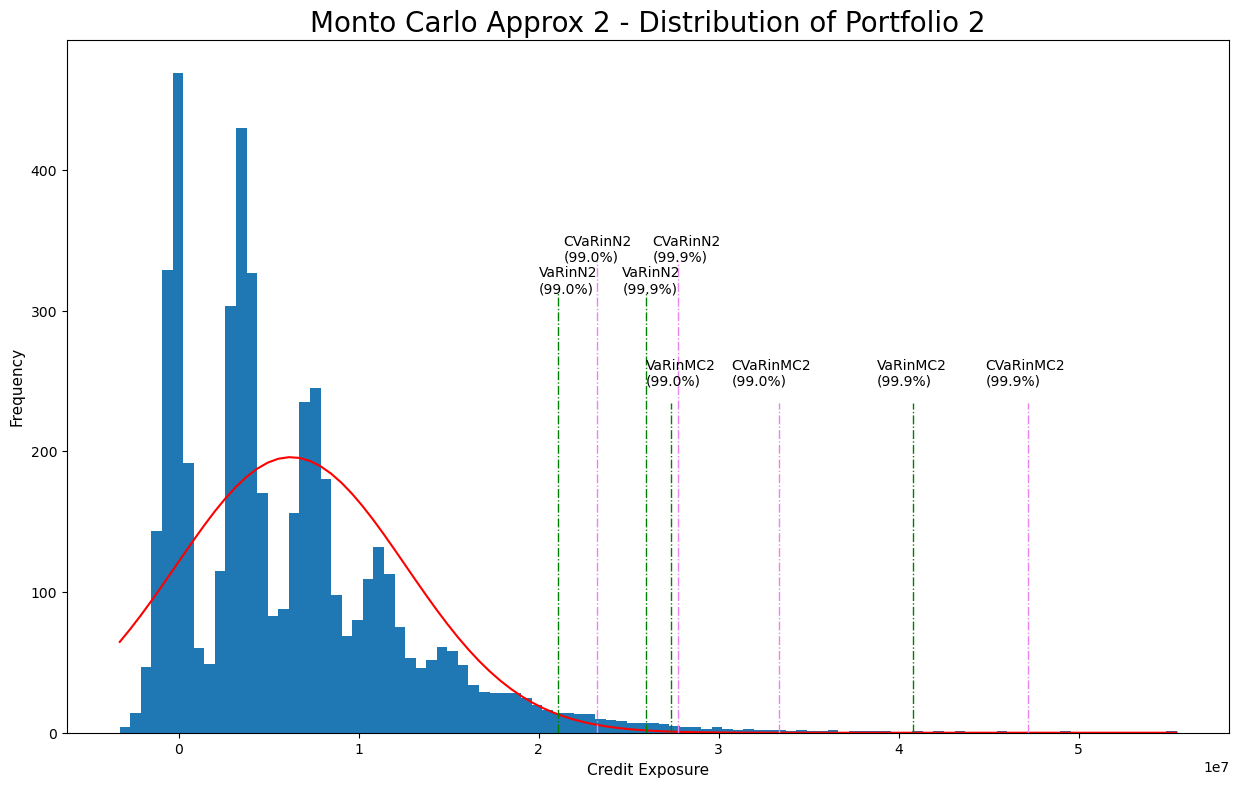

In [42]:
# Distribution of Portfolio 2 Monte Carlo approximation 2, portfolio 2, N = 5000
VaRinMC2_p2_99 = np.mean(VaRinMC2[1, 0])
VaRinMC2_p2_999 = np.mean(VaRinMC2[1, 1])
CVaRinMC2_p2_99 = np.mean(CVaRinMC2[1, 0])
CVaRinMC2_p2_999 = np.mean(CVaRinMC2[1, 1])

plt.figure(figsize=(15,9))
frequencyCounts, binLocations, patches = plt.hist(port_loss_inMC2_p2, 100)
normf = (1 / (np.std(port_loss_inMC2_p2) * math.sqrt(2 * math.pi))) * np.exp(-0.5 * ((binLocations - np.mean(port_loss_inMC2_p2)) / np.std(port_loss_inMC2_p2)) ** 2)
normf = normf * sum(frequencyCounts) / sum(normf)
plt.plot(binLocations, normf, color='r', linewidth=1.5)
plt.plot([VaRinMC2_p2_99, VaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.0%)')
plt.plot([VaRinMC2_p2_999, VaRinMC2_p2_999], [0, max(frequencyCounts)/2], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinMC2_p2_999, max(frequencyCounts) / 1.9, 'VaRinMC2\n(99.9%)')
plt.plot([CVaRinMC2_p2_99, CVaRinMC2_p2_99], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinMC2_p2_99, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.0%)')
plt.plot([CVaRinMC2_p2_999, CVaRinMC2_p2_999], [0, max(frequencyCounts)/2], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinMC2_p2_999, max(frequencyCounts) / 1.9, 'CVaRinMC2\n(99.9%)')

# Normal distribution of Monte Carlo approximation 1, portfolio 1 
VaRinN2_p2_99 = np.mean(VaRinN2[1, 0])
VaRinN2_p2_999 = np.mean(VaRinN2[1, 1])
CVaRinN2_p2_99 = np.mean(CVaRinN2[1, 0])
CVaRinN2_p2_999 = np.mean(CVaRinN2[1, 1])

plt.plot([VaRinN2_p2_99, VaRinN2_p2_99], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_99, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.0%)')
plt.plot([VaRinN2_p2_999, VaRinN2_p2_999], [0, max(frequencyCounts)/1.5], color='green', linewidth=1, linestyle='-.')
plt.text(0.95 * VaRinN2_p2_999, max(frequencyCounts) / 1.5, 'VaRinN2\n(99.9%)')
plt.plot([CVaRinN2_p2_99, CVaRinN2_p2_99], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.92 * CVaRinN2_p2_99, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.0%)')
plt.plot([CVaRinN2_p2_999, CVaRinN2_p2_999], [0, max(frequencyCounts)/1.4], color='violet', linewidth=1, linestyle='-.')
plt.text(0.95 * CVaRinN2_p2_999, max(frequencyCounts) / 1.4, 'CVaRinN2\n(99.9%)')


plt.title('Monto Carlo Approx 2 - Distribution of Portfolio 2', fontsize=20)
plt.xlabel('Credit Exposure', fontsize = 11)
plt.ylabel('Frequency', fontsize = 11);